In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Fri Jan 19 00:29:45 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   47C    P0    71W / 300W |   8433MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.rand_prior import Prior
from model.latent.lse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.n_prior_embeddings = 8192
hp.z_activation = F.tanh
hp.activation = F.sigmoid
hp.init_log_sigma = -1

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 4.0
latent 3.814697265625e-06
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.18-7/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 47364
-rw-rw-r-- 1 scpark scpark   120260  1월 19 00:29 events.out.tfevents.1705591417.GPUSVR11
-rw-rw-r-- 1 scpark scpark 48371246  1월 19 00:24 save_0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.5572], device='cuda:0', grad_fn=<ExpBackward0>)


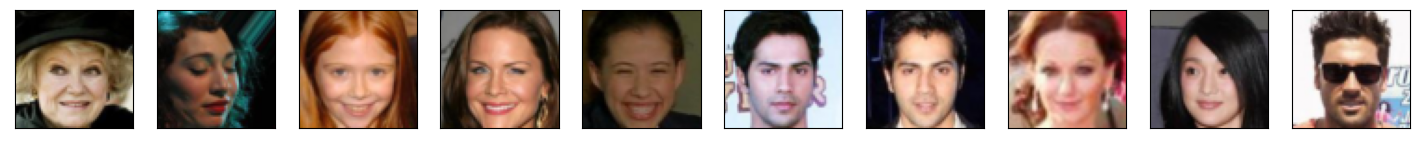

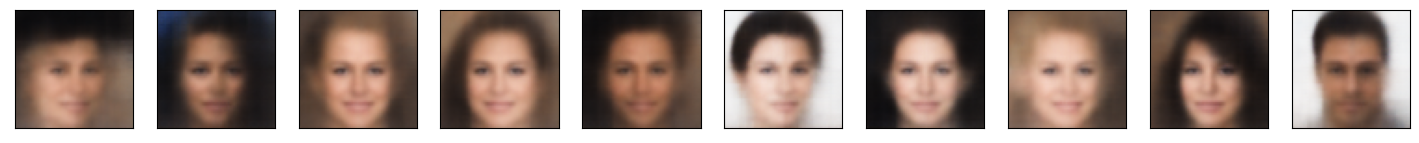

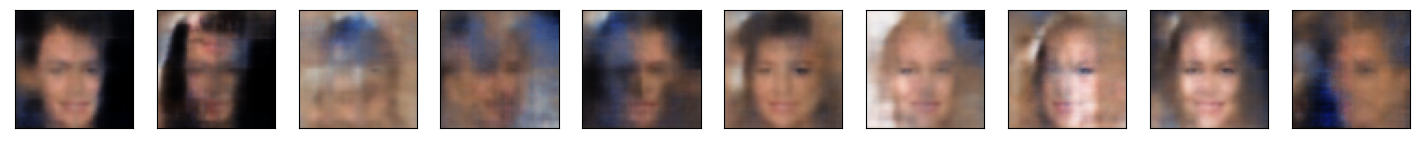

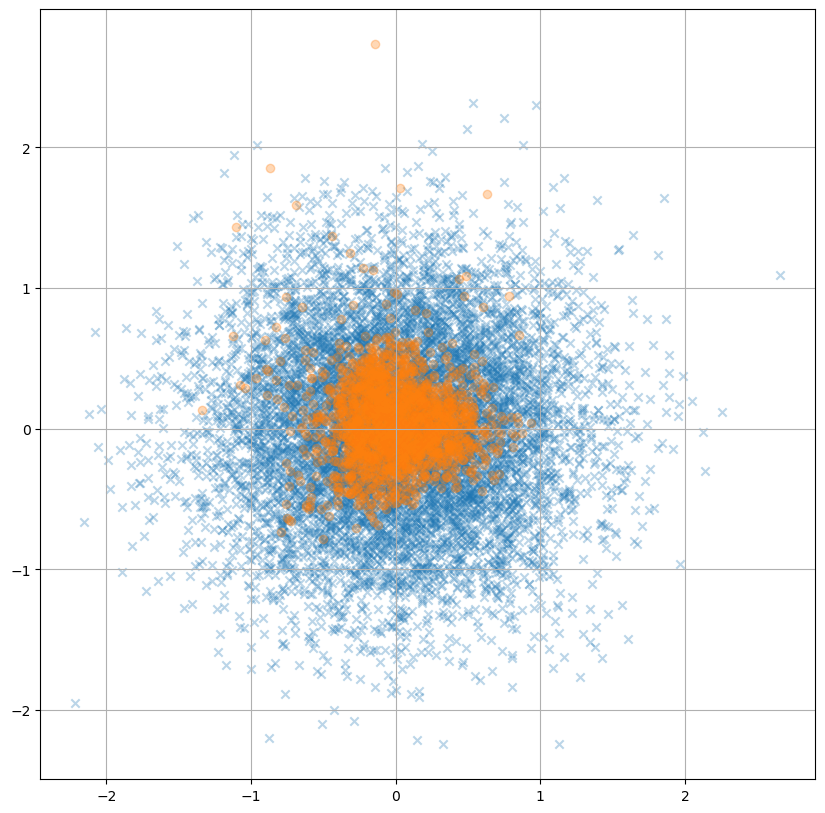

3001
lse_loss -71.2027587890625
recon_loss 0.023089881986379623
3002
lse_loss -71.20599365234375
recon_loss 0.024133890867233276
3003
lse_loss -71.15928649902344
recon_loss 0.02443593554198742
3004
lse_loss -71.196533203125
recon_loss 0.024982575327157974
3005
lse_loss -71.04216003417969
recon_loss 0.024277573451399803
3006
lse_loss -71.24642944335938
recon_loss 0.024836093187332153
3007
lse_loss -71.13560485839844
recon_loss 0.025534596294164658
3008
lse_loss -71.15794372558594
recon_loss 0.024367457255721092
3009
lse_loss -71.15823364257812
recon_loss 0.02394934743642807
3010
lse_loss -71.18853759765625
recon_loss 0.023187529295682907
3011
lse_loss -71.17488098144531
recon_loss 0.02395450696349144
3012
lse_loss -71.16973876953125
recon_loss 0.024068091064691544
3013
lse_loss -71.19703674316406
recon_loss 0.023399129509925842
3014
lse_loss -71.24433898925781
recon_loss 0.02302892506122589
3015
lse_loss -71.17683410644531
recon_loss 0.023728124797344208
3016
lse_loss -71.16256713867188

3129
lse_loss -71.26860046386719
recon_loss 0.02377903275191784
3130
lse_loss -71.26177978515625
recon_loss 0.02301447093486786
3131
lse_loss -71.23052978515625
recon_loss 0.024044429883360863
3132
lse_loss -71.251220703125
recon_loss 0.024345070123672485
3133
lse_loss -71.26954650878906
recon_loss 0.0233636274933815
3134
lse_loss -71.21287536621094
recon_loss 0.024438466876745224
3135
lse_loss -71.231201171875
recon_loss 0.02409142255783081
3136
lse_loss -71.22776794433594
recon_loss 0.023435957729816437
3137
lse_loss -71.19827270507812
recon_loss 0.025106925517320633
3138
lse_loss -71.21388244628906
recon_loss 0.025019671767950058
3139
lse_loss -71.2708740234375
recon_loss 0.024225976318120956
3140
lse_loss -71.16522216796875
recon_loss 0.024140117689967155
3141
lse_loss -71.20686340332031
recon_loss 0.02409222349524498
3142
lse_loss -71.16218566894531
recon_loss 0.023936253041028976
3143
lse_loss -71.16592407226562
recon_loss 0.02305573783814907
3144
lse_loss -71.23362731933594
reco

3257
lse_loss -71.24148559570312
recon_loss 0.023812880739569664
3258
lse_loss -71.03837585449219
recon_loss 0.024714848026633263
3259
lse_loss -71.24546813964844
recon_loss 0.025316212326288223
3260
lse_loss -71.16557312011719
recon_loss 0.02431689016520977
3261
lse_loss -71.12399291992188
recon_loss 0.023530876263976097
3262
lse_loss -71.19407653808594
recon_loss 0.024956626817584038
3263
lse_loss -71.15837097167969
recon_loss 0.0246889628469944
3264
lse_loss -71.20848083496094
recon_loss 0.024311138316988945
3265
lse_loss -71.10606384277344
recon_loss 0.02597486600279808
3266
lse_loss -71.18254089355469
recon_loss 0.02543775737285614
3267
lse_loss -71.21119689941406
recon_loss 0.02718823216855526
3268
lse_loss -71.2054443359375
recon_loss 0.024786725640296936
3269
lse_loss -71.18850708007812
recon_loss 0.024671724066138268
3270
lse_loss -71.20584106445312
recon_loss 0.024388065561652184
3271
lse_loss -71.17387390136719
recon_loss 0.02575809881091118
3272
lse_loss -71.19056701660156


3385
lse_loss -71.24690246582031
recon_loss 0.02575967088341713
3386
lse_loss -71.22467041015625
recon_loss 0.025563983246684074
3387
lse_loss -71.26438903808594
recon_loss 0.024556603282690048
3388
lse_loss -71.25985717773438
recon_loss 0.026470905169844627
3389
lse_loss -71.26095581054688
recon_loss 0.02458326518535614
3390
lse_loss -71.24005126953125
recon_loss 0.024029847234487534
3391
lse_loss -71.28085327148438
recon_loss 0.02430148795247078
3392
lse_loss -71.25825500488281
recon_loss 0.02423478290438652
3393
lse_loss -71.32833862304688
recon_loss 0.02423817478120327
3394
lse_loss -71.28453063964844
recon_loss 0.025205334648489952
3395
lse_loss -71.29483032226562
recon_loss 0.025538494810461998
3396
lse_loss -71.26290893554688
recon_loss 0.024381957948207855
3397
lse_loss -71.21853637695312
recon_loss 0.024434244260191917
3398
lse_loss -71.27369689941406
recon_loss 0.025354092940688133
3399
lse_loss -71.28370666503906
recon_loss 0.024009939283132553
3400
lse_loss -71.244720458984

3513
lse_loss -71.32339477539062
recon_loss 0.02446463331580162
3514
lse_loss -71.2880859375
recon_loss 0.02507496252655983
3515
lse_loss -71.2952880859375
recon_loss 0.02579331025481224
3516
lse_loss -71.28054809570312
recon_loss 0.024983054026961327
3517
lse_loss -71.30888366699219
recon_loss 0.026298630982637405
3518
lse_loss -71.29148864746094
recon_loss 0.02416912466287613
3519
lse_loss -71.26824951171875
recon_loss 0.025735093280673027
3520
lse_loss -71.29644775390625
recon_loss 0.025131933391094208
3521
lse_loss -71.30287170410156
recon_loss 0.02580466866493225
3522
lse_loss -71.31240844726562
recon_loss 0.024736177176237106
3523
lse_loss -71.31681823730469
recon_loss 0.023268889635801315
3524
lse_loss -71.2557373046875
recon_loss 0.02566608414053917
3525
lse_loss -71.27729797363281
recon_loss 0.0230849739164114
3526
lse_loss -71.29505920410156
recon_loss 0.025285400450229645
3527
lse_loss -71.25788879394531
recon_loss 0.024540618062019348
3528
lse_loss -71.32757568359375
recon_

3641
lse_loss -70.59974670410156
recon_loss 0.030576582998037338
3642
lse_loss -70.63710021972656
recon_loss 0.03070923686027527
3643
lse_loss -70.67988586425781
recon_loss 0.029003500938415527
3644
lse_loss -70.70333862304688
recon_loss 0.03050624579191208
3645
lse_loss -70.71763610839844
recon_loss 0.028604818508028984
3646
lse_loss -70.74458312988281
recon_loss 0.03016771748661995
3647
lse_loss -70.67658996582031
recon_loss 0.02994360402226448
3648
lse_loss -70.777587890625
recon_loss 0.029248764738440514
3649
lse_loss -70.77888488769531
recon_loss 0.030345207080245018
3650
lse_loss -70.85958862304688
recon_loss 0.02894587442278862
3651
lse_loss -70.84213256835938
recon_loss 0.028710786253213882
3652
lse_loss -70.89167785644531
recon_loss 0.02806931361556053
3653
lse_loss -70.84565734863281
recon_loss 0.029026813805103302
3654
lse_loss -70.9161376953125
recon_loss 0.027785491198301315
3655
lse_loss -70.89485168457031
recon_loss 0.029939446598291397
3656
lse_loss -70.93125915527344
r

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            print(torch.exp(model.latent.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample().to(device)
                y = model.sample(z)
                plot(y)
                
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.3)
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.3)
            plt.grid()
            plt.show()    
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')